In [212]:
import pandas as pd
from datetime import datetime, timedelta
import calendar, datetime
import geopandas as gpd
import matplotlib.pyplot as plt

In [195]:
table = pd.read_csv('table11.csv', header=None)
dateList = []
for date in table[0]:
    # print (date)
    date = datetime.strptime(date, "%m/%d/%Y")
    dateList.append(date)

In [196]:

startDateList = []
endDateList = []
for date in dateList:
    startDateList.append(date - timedelta(days = 7))
    endDateList.append(date + timedelta(days = 7))
zipList = list(zip(dateList, startDateList, endDateList))

In [197]:
dateTable = pd.DataFrame(zipList, columns=['Event', 'StartDate', 'EndDate'])

In [198]:
# Data csv pulled from:
# https://mesonet.agron.iastate.edu/request/download.phtml?network=LA_ASOS

data_df = pd.read_csv(r"Z:\temp\asos.txt")


In [199]:
data_df.head(3)

,station,valid,lon,lat,elevation,sped
0,NEW,1942-09-01 06:00,-90.0282,30.0424,3.0,5.75
1,NEW,1942-09-01 07:00,-90.0282,30.0424,3.0,4.60
2,NEW,1942-09-01 08:00,-90.0282,30.0424,3.0,3.45


In [200]:
gageList = data_df.station.unique()

In [255]:
# Get first and last row of each gage to capture geometry and date range
gdf_columns = ['gage', 'lat', 'lon', 'startDate', 'endDate']
latList = []
lonList = []
sList = []
eList = []
# gdf_dict = {}
for gage in gageList:
    # print (gage)
    gage_df = data_df[data_df['station'] == gage]
    startDate_por = gage_df['valid'].iloc[0]
    endDate_por = gage_df['valid'].iloc[-1]
    lat = gage_df['lat'].iloc[0]
    lon = gage_df['lon'].iloc[0]
    sList.append(startDate_por)
    eList.append(endDate_por)
    latList.append(lat)
    lonList.append(lon)

In [256]:
# Make a map of the gage Locations
# Create geodataframe
df = pd.DataFrame(
    {'gage': gageList,
     'startDate': sList,
     'endDate': eList,
     'Latitude': latList,
     'Longitude': lonList})
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

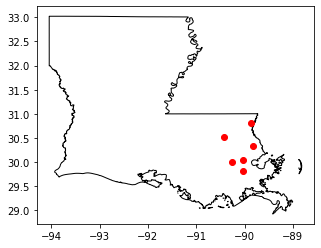

In [257]:

la = gpd.read_file("Z:\GIS\Louisiana.shp")

# We restrict to South America.
ax = la.plot(
    color='white', edgecolor='black', )

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
# ax.annotate(gage)

plt.show()

In [258]:
#gdf to shp
gdf.to_file('gages.shp')
gdf.to_file('gages.geojson', driver="GeoJSON")

c:\Tools\Anaconda3\envs\XrRio\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Tools\Anaconda3\envs\XrRio\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [204]:
# convert the 'Date' column to datetime format
data_df['Date']= pd.to_datetime(data_df['valid'])
 
# Check the format of 'Date' column
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4757479 entries, 0 to 4757478
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   station    object        
 1   valid      object        
 2   lon        float64       
 3   lat        float64       
 4   elevation  float64       
 5   sped       float64       
 6   Date       datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 254.1+ MB


In [260]:
resultsTableLength = len(dateList)
appended_data_por = []
# For each gage and each event get Mean Wind Speed Value.
for gage in gageList:
    # Filter data by gage
    gage_df = data_df[data_df['station'] == gage]
    # Filter data seasonally by each event (each event is in dateTable)
    for i, row in dateTable.T.iteritems():
        # print (date)
        startDate = row['StartDate']
        endDate = row['EndDate']
        
        
        # get days in month
        daysInStartMonth= calendar.monthrange(startDate.year, startDate.month)[1]
        daysInEndMonth= calendar.monthrange(endDate.year, endDate.month)[1]

        # Filter dataframe from to only contain data from startDate to endDate
        startMonth_DayRange = gage_df[gage_df['Date'].dt.month == startDate.month]
        startMonth_DayRange = startMonth_DayRange[startMonth_DayRange['Date'].dt.day >= startDate.day]
        endMonth_DayRange = gage_df[gage_df['Date'].dt.month == endDate.month]
        endMonth_DayRange = endMonth_DayRange[endMonth_DayRange['Date'].dt.day <= endDate.day]
        filtered_df = pd.concat([startMonth_DayRange, endMonth_DayRange])
        
        # Get Period of Record mean for each event
        mean = round(filtered_df.sped.mean(),2)

        # Dictionary format to hold PoR Summary Results
        result_data_por = {
            'Gage': gage,
            'PoR Mean Wind Speed (mph)': mean,
            'Event': row['Event'],
            'Event Start Date': f'{startDate.month}-{startDate.day}',
            'Event End Date': f'{endDate.month}-{endDate.day}'
            }
        appended_data_por.append(result_data_por)        

In [252]:
results_df = pd.DataFrame.from_dict(appended_data_por) 
results_df.to_csv (r'results_por.csv', index = False, header=True)

In [177]:
# get day range
startDate.day
startMonth_DayRange = gage_df[
    (gage_df['Date'].dt.month == startDate.month) 
    & (gage_df['Date'].dt.day >= startDate.day) 
    & (gage_df['Date'].dt.day <= daysInStartMonth)
]
endMonth_DayRange = gage_df['Date'].dt.month.eq(endDate.month)&gage_df['Date'].dt.day.between(endDate.day,daysInEndMonth)